In [195]:
from faiss.contrib.datasets import DatasetSIFT1M, SyntheticDataset, DatasetDeep1B
from faiss.contrib.inspect_tools import get_invlist
import faiss

# ds = DatasetDeep1B(int(1e6))
ds = DatasetSIFT1M()
index_string = 'IVF32,PQ16'

index = faiss.index_factory(ds.d, index_string)
index.train(ds.get_train())
database = ds.get_database()
index.add(database)
num_clusters = index.invlists.nlist

get_invlist(index.invlists, 0)

(array([    16,     27,    111, ..., 999854, 999921, 999989]),
 array([[194, 210, 175, ..., 159, 113,   8],
        [194, 210, 199, ..., 251,  89, 128],
        [156, 234, 226, ..., 235, 103,  83],
        ...,
        [253,  78,  70, ..., 190, 187, 175],
        [125,  99,  20, ..., 186, 175, 136],
        [ 66, 208, 203, ..., 186, 185,  19]], dtype=uint8))

In [196]:
import numpy as np

def compute_mutual_info(X):
    num_examples, num_vars = X.shape
    MI = np.zeros((num_vars, num_vars)) + np.nan

    match X.dtype:
        case np.uint8:
            double_bit_depth = np.uint16
        case np.uint16:
            double_bit_depth = np.uint32
        case np.uint32:
            double_bit_depth = np.uint64
        case _:
            raise ValueError()

    for i in range(num_vars):
        for j in range(i+1):
            x = X[:, i]
            y = X[:, j]

            _, x_counts = np.unique(x, return_counts=True)
            _, y_counts = np.unique(y, return_counts=True)

            x_prob = x_counts/num_examples
            y_prob = y_counts/num_examples

            Hx = -np.sum(x_prob*np.log2(x_prob))
            Hy = -np.sum(y_prob*np.log2(y_prob))

            xy_combined = np.ascontiguousarray(np.stack([x, y], axis=1)).view(double_bit_depth)
            _, xy_counts = np.unique(xy_combined, return_counts=True)
            xy_probs = xy_counts/num_examples

            Hxy = -np.sum(xy_probs*np.log2(xy_probs))

            MI[i, j] = Hx + Hy - Hxy

    return MI

codes_per_cluster = [get_invlist(index.invlists, c)[1] for c in range(num_clusters)]
codes_all = np.concatenate(codes_per_cluster)

print('MI for all codes')
display(compute_mutual_info(codes_all[:, :5]))

for i, codes in enumerate(codes_per_cluster[:3]):
    print('MI for codes in voronoi cell', i)
    display(compute_mutual_info(codes[:, :5]))

MI for all codes


array([[7.78535184,        nan,        nan,        nan,        nan],
       [1.04931694, 7.80719911,        nan,        nan,        nan],
       [0.46466847, 1.24985629, 7.7928114 ,        nan,        nan],
       [0.24824851, 0.44086636, 1.00126785, 7.78474492,        nan],
       [1.16080552, 0.70805265, 0.55408427, 0.30922823, 7.79701073]])

MI for codes in voronoi cell 0


array([[6.94281713,        nan,        nan,        nan,        nan],
       [1.58694412, 6.65210503,        nan,        nan,        nan],
       [1.20762664, 1.49973929, 6.84002532,        nan,        nan],
       [1.16082575, 1.07105731, 1.36549853, 6.82820619,        nan],
       [1.53843258, 1.11953557, 1.00696677, 1.03734014, 6.48060704]])

MI for codes in voronoi cell 1


array([[6.67173225,        nan,        nan,        nan,        nan],
       [1.31511799, 6.76681138,        nan,        nan,        nan],
       [0.63052891, 1.09607494, 6.87507913,        nan,        nan],
       [0.64074743, 0.69540239, 1.17051455, 7.34654382,        nan],
       [1.25487342, 0.86433174, 0.56639532, 0.63374885, 6.64725817]])

MI for codes in voronoi cell 2


array([[7.00407546,        nan,        nan,        nan,        nan],
       [1.17333864, 6.68669436,        nan,        nan,        nan],
       [0.7420892 , 1.06545022, 6.58284521,        nan,        nan],
       [0.80098664, 0.74155713, 1.29042678, 6.87426284,        nan],
       [1.31360774, 0.71665726, 0.58712816, 0.63855909, 6.19400574]])

In [3]:
num_vars = codes_all.shape[1]
mask = np.eye(num_vars).astype(bool)
MI = compute_mutual_info(codes_all)
coding_cost_iid = MI[mask].sum()/num_vars

MI_per_cluster = [compute_mutual_info(code) for code in codes_per_cluster]
coding_cost_iid_per_cluster = [MI[mask].sum() for MI in MI_per_cluster]

KeyboardInterrupt: 

In [10]:
coding_cost_iid_per_cluster = sum([MI[mask].sum()*codes.shape[0] for codes, MI in zip(codes_per_cluster, MI_per_cluster)])/np.prod(codes_all.shape)
coding_cost_iid_per_cluster, 100*(1 - coding_cost_iid_per_cluster/8)

(7.452397740132317, 6.845028248346042)

In [11]:
coding_cost_iid, 100*(1 - coding_cost_iid/8)

(7.904536531206379, 1.1932933599202666)

# Conclusion
- The measured entropy of codes, when restricted to the same cluster, is around `6.21 bpe`, around `22%` below the reference `8 bpe` (i.e., 1 byte). Note this is for the element of each code, and not the entire code. For example, `PQ16` has `16` elements, so the reference cost of a single code-word would be `16*8 = 128 bits`, while the average entropy of an entire code-word would be `6.21*8 = 99. bits`

- When measuring entropy by taking all vectors into account, the entropy is significantly higher, at `7.79 bpe`.

- This means we should be able to compress codes by roughly `22%` with a simple count-based entropy coder.

- If we are willing to pay the price of coding pair-wise elements, then a savings equal to the MI is also realizable. The target rate would be `H(Y |X) = H(X) + I(X; Y)`. In other words, we can estimate the savings by subtracting the MI (off-diagonal) from the marginal entropy (diagonal), bring the total compute cost closer to `3 bpe` or maybe even `2 bpe`. **However, I think it mostly has to do with sparseness. A pair of code elements has `2^16 ~= 65k` possible values, while a single cluster has much less than that. This means the cost of encoding the distribution itself has to be taken into acount, otherwise these numbers can be misleading.**

- If pair-wise compression it to be done, there's the question of which ordering to perform it in. This actually has an answer: the order is defined my taking the maximum spanning tree of the MI matrix, also known as a "Chow-Liu Tree".

- Doing this requires implementing vectorized ANS, otherwise speed would be a major issue.


# Sanity checks

# Pairwise counts per cluster

(16604, 16)

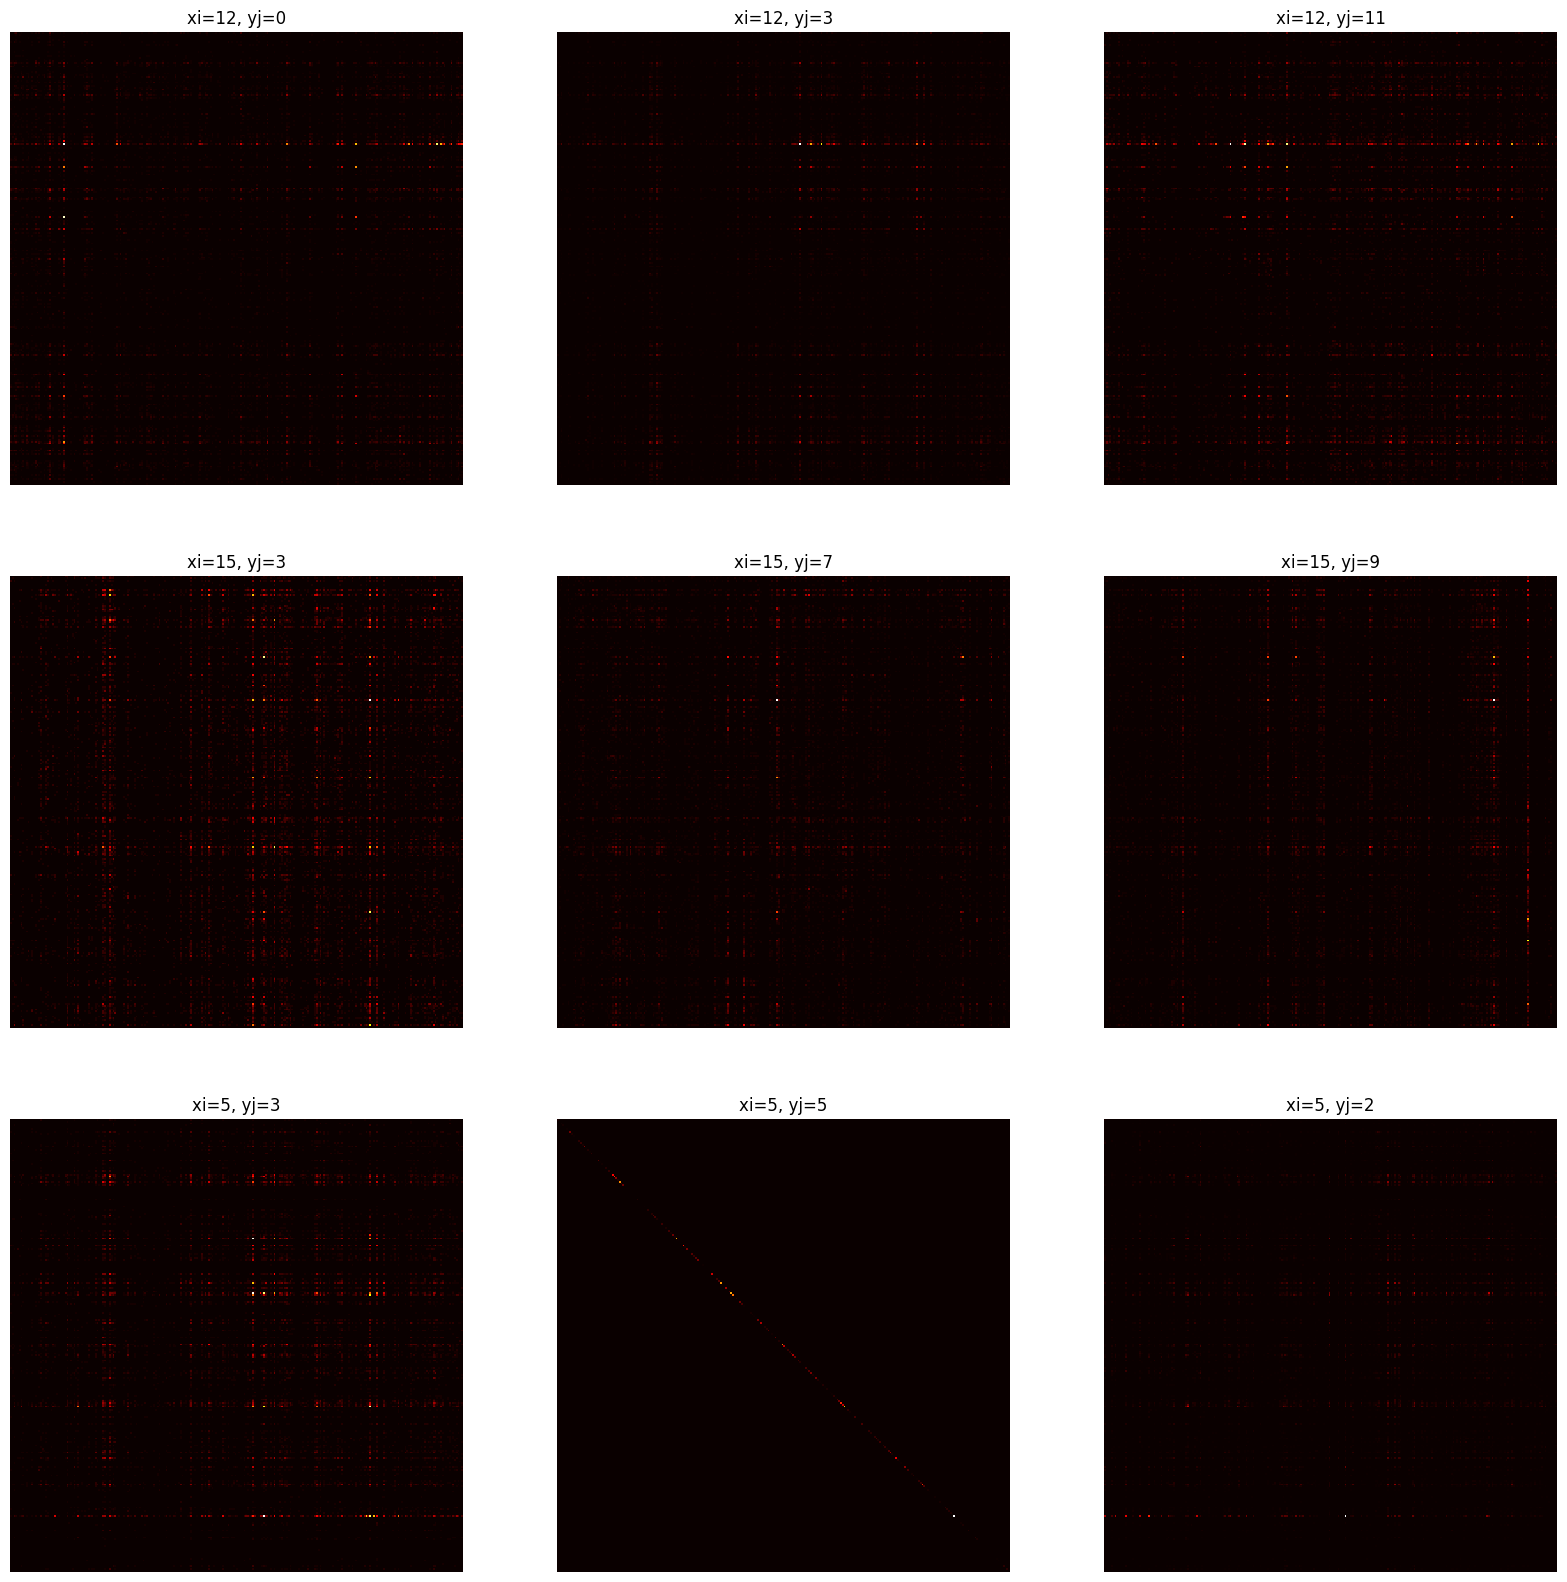

In [197]:
import numpy as np
import matplotlib.pyplot as plt

codes = codes_per_cluster[0]
display(codes.shape)

N = 3
fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(20, 20))
pairwise_counts = np.zeros((N, N, 256, 256), dtype=np.uint16)
np.random.seed(0)
for i, xi in enumerate(np.random.randint(16, size=N)):
    for j, yj in enumerate(np.random.randint(16, size=N)):
        codes_pairs = np.ascontiguousarray(codes[:, [xi, yj]]).view(np.uint16)
        pairs, counts = np.unique(codes_pairs, return_counts=True)
        pairwise_counts[i, j, pairs % 256, pairs // 256] = counts
        axes[i, j].set_title(f'{xi=}, {yj=}')
        axes[i, j].imshow(pairwise_counts[i, j].reshape(256, 256) , cmap='hot', interpolation='nearest')
        axes[i, j].axis('off')

plt.show()

In [185]:
pairwise_counts += 1
px = (p := pairwise_counts[i, j].sum(axis=1))/p.sum()
py = (p := pairwise_counts[i, j].sum(axis=0))/p.sum()
pxy = pairwise_counts[i, j]/pairwise_counts[i, j].sum()

Hx = -np.sum(px[px > 0]*np.log2(px[px > 0]))
Hy = -np.sum(py[py > 0]*np.log2(py[py > 0]))
Hxy = -np.sum(pxy[pxy > 0]*np.log2(pxy[pxy > 0]))
MI = Hx + Hy - Hxy
MI

0.00016628575538035761

(1000000, 16)

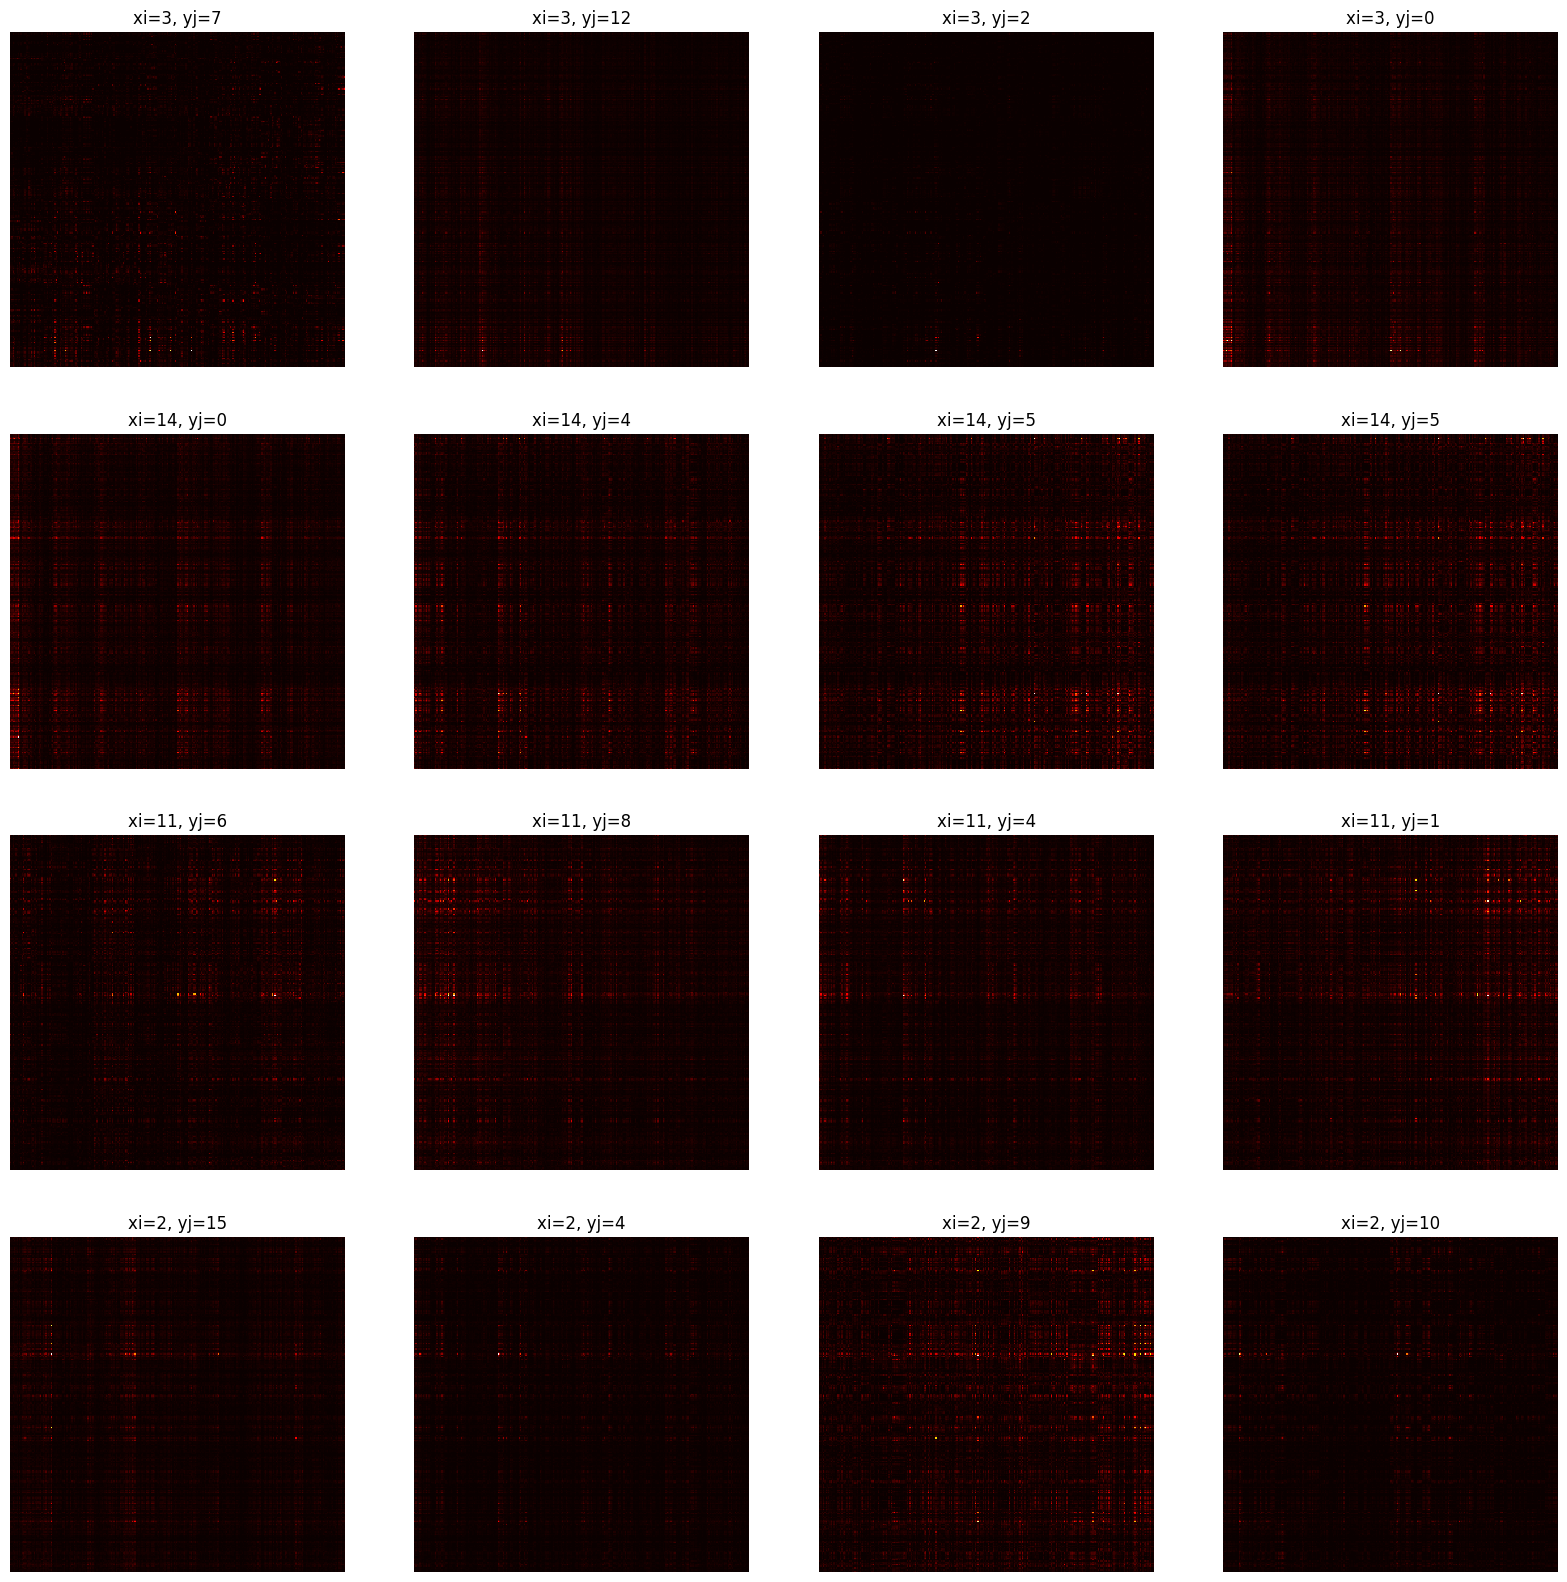

In [180]:
import numpy as np
import matplotlib.pyplot as plt

codes = codes_all
display(codes.shape)

N = 4
fig, axes = plt.subplots(nrows=N, ncols=N, figsize=(20, 20))
pairwise_counts = np.zeros((N, N, 256, 256), dtype=np.uint16)
for i, xi in enumerate(np.random.randint(16, size=N)):
    for j, yj in enumerate(np.random.randint(16, size=N)):
        codes_pairs = np.ascontiguousarray(codes[:, [xi, yj]]).view(np.uint16)
        pairs, counts = np.unique(codes_pairs, return_counts=True)
        pairwise_counts[i, j, pairs % 256, pairs // 256] = counts
        axes[i, j].set_title(f'{xi=}, {yj=}')
        axes[i, j].imshow(pairwise_counts[i, j].reshape(256, 256) , cmap='hot', interpolation='nearest')
        axes[i, j].axis('off')

plt.show()